In [1]:
import sys
import pandas as pd
import numpy as np
from time import time

from datetime import datetime
from tqdm import tqdm_notebook
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Lambda
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.backend import sparse_categorical_crossentropy, categorical_crossentropy
from tensorflow.keras.layers import Dense, TimeDistributed

print("TF version: ", tf.__version__)
print("Hub version: ", hub.__version__)

/home/vijjus/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/vijjus/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/vijjus/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/vijjus/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dty

TF version:  1.14.0
Hub version:  0.7.0


In [2]:
local_bert_path =   '/home/vijjus/bert/bert/'
data_path = '/home/vijjus/datasets/'  # path to ner_dataset.csv file , from 

now = datetime.now() # current date and time

# make sure that the paths are accessible within the notebook
sys.path.insert(0,local_bert_path)
sys.path.insert(0,data_path)

In [3]:
import optimization
import run_classifier
import tokenization
import run_classifier_with_tfhub

I will limit the sentences to 64 tokens.

In [4]:
# Tensorflow hub path to BERT module of choice
bert_url = "https://tfhub.dev/google/bert_cased_L-12_H-768_A-12/1"

# Define maximal length of input 'sentences' (post tokenization).
max_length = 64

## Data Preprocessing ##

BERT uses the wordpiece tokenizer. With this tokenizer, the original CDC dataset can be used. 

In [5]:
def create_tokenizer_from_hub_module():
    """Get the vocab file and casing info from the Hub module."""
    with tf.Graph().as_default():
        bert_module = hub.Module(bert_url)
        tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
        with tf.Session() as sess:
            vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
    return tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

In [6]:
tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [7]:
def addWord(word):
    """
    
    arguments: word
    returns: dictionary with tokens and labels
    """
    # the dataset contains various '"""' combinations which we choose to truncate to '"', etc. 
    if word == '""""':
        word = '"'
    elif word == '``':
        word = '`'
        
    tokens = tokenizer.tokenize(word)
    tokenLength = len(tokens)      # find number of tokens corresponfing to word to later add 'X' tokens to labels
    
    addDict = dict()
    
    addDict['wordToken'] = tokens
    addDict['tokenLength'] = tokenLength
    
    return addDict

In [8]:
df = pd.read_csv(data_path + 'cdc_train.csv')

In [9]:
df.head()

,text,sex,age,event
0,57YOM WITH CONTUSION TO FACE AFTER STRIKING IT...,1,57,62
1,A 45YOM FELL ON ARM WHILE WORKING HAD SLIPPED ...,1,45,42
2,58YOM WITH CERVICAL STRAIN BACK PAIN S P REST...,1,58,26
3,33 YOM LAC TO HAND FROM A RAZOR KNIFE,1,33,60
4,53YOM AT WORK IN A WAREHOUSE DOING UNSPECIFIED...,1,53,71


In [10]:
"""
Read the file line by line and construct sentences. A sentence end is marked by the word 'sentence' in the next row.
You need to take care of that. Also, you need to cap sentence length using max_length. Sentences which are shorter than 
max_length need to be padded. Also, we choose to end all sentences with a [SEP] token, padded or not. 
"""

# lists for sentences, tokens, labels, etc.  
sentenceList = []
sentenceTokenList = []
sentLengthList = []

# lists for BERT input
bertSentenceIDs = []
bertMasks = []
bertSequenceIDs = []

labels = []

total_len = len(df)

for i in tqdm_notebook(range(total_len)):
    
    # always start with [CLS] tokens
    sentenceTokens = ['[CLS]']
    
    text = df.iloc[i]['text'].lower()
    
    labels.append(int(df.iloc[i]['event']))
    
    words = text.split(" ")
    
    for word in words:
        addDict = addWord(word)
        sentenceTokens += addDict['wordToken']
    sentenceTokens += ['[SEP]'] + ['[PAD]'] * (max_length -1 - len(sentenceTokens))
    
    sentenceList.append(text)
    sentenceTokenList.append(sentenceTokens)
    sentLengthList.append(len(sentenceTokens))

    sentenceLength = min(max_length - 1, len(sentenceTokens))
    bertSentenceIDs.append(tokenizer.convert_tokens_to_ids(sentenceTokens))
    bertMasks.append([1] * (sentenceLength + 1) + [0] * (max_length - 1 - sentenceLength))
    bertSequenceIDs.append([0] * (max_length))

In [11]:
sentenceList[2]

'58yom with cervical strain  back pain s p restrained taxi driver in low speed rear end mvc no loc no ab deployed'

In [12]:
len(labels)

153956

(array([8.9370e+03, 5.4920e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        4.8000e+01, 5.0000e+01, 1.2990e+03, 2.7880e+03, 8.4400e+02,
        2.0000e+00, 1.2320e+03, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.5620e+03, 2.2173e+04, 3.8600e+02, 0.0000e+00,
        0.0000e+00, 5.2000e+01, 9.7000e+02, 3.9070e+03, 1.1678e+04,
        0.0000e+00, 8.9860e+03, 5.2000e+01, 3.3460e+04, 4.4290e+03,
        2.9330e+03, 9.6000e+01, 3.1225e+04, 9.0780e+03, 4.0000e+00,
        0.0000e+00, 8.8800e+02, 1.2000e+01, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.3730e+03]),
 array([10.        , 11.85416667, 13.70833333, 15.5625    , 17.41666667,
        19.27083333, 21.125     , 22.97916667, 24.83333333, 26.6875    ,
        28.54166667, 30.39583333, 32.25      , 34.10416667, 35.95833333,
        37.8125    , 39.66666667, 41.52083333, 43.375     , 45.22916667,
        47.08333333, 48.9375    , 50.79166667, 52.

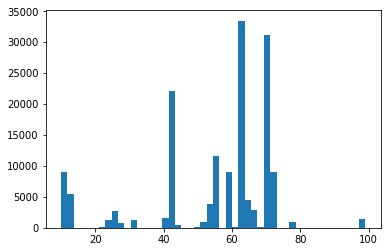

In [13]:
plt.hist(labels, bins=48)

In [14]:
len(bertSequenceIDs[0])

64

(array([     0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0., 153956.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.]),
 array([63.5       , 63.51612903, 63.53225806, 63.5483871 , 63.56451613,
        63.58064516, 63.59677419, 63.61290323, 63.62903226, 63.64516129,
        63.66129032, 63.67741935, 63.69354839, 63.70967742, 63.72580645,
        63.74193548, 63.75806452, 63.77419355, 63.79032258, 63.80645161,
        63.82258065, 63.83870968, 63.85483871, 63.87096774, 63.88709677,
   

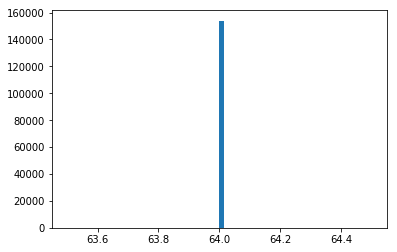

In [15]:
sentenceLengths= [l for l in sentLengthList]

plt.hist(np.array(sentenceLengths), bins=(max_length-2))

In [16]:
bert_inputs = np.array([bertSentenceIDs, bertMasks, bertSequenceIDs])

In [17]:
bert_inputs.shape

(3, 153956, 64)

In [18]:
numSentences = len(bert_inputs[0])
np.random.seed(0)
training_examples = np.random.binomial(1, 0.7, numSentences)
num_training_examples = np.sum(training_examples)
num_test_examples = numSentences - num_training_examples

In [19]:
numSentences

153956

In [20]:
event_labels = np.array(labels)

In [21]:
labels[:10]

[62, 42, 26, 60, 71, 62, 60, 69, 71, 71]

In [22]:
event2id = {}
id2event = {}
events = sorted(set(labels))
for i, event in enumerate(events):
    event2id[event] = i
    id2event[i] = event

In [23]:
numClasses = df.event.nunique()

In [24]:
trainSentence_ids = []
trainMasks = []
trainSequence_ids = []

testSentence_ids = []
testMasks = []
testSequence_ids = []

Labels_train_list = []
Labels_test_list = []

for example in range(numSentences):
    if training_examples[example] == 1:
        trainSentence_ids.append(bert_inputs[0][example])
        trainMasks.append(bert_inputs[1][example])
        trainSequence_ids.append(bert_inputs[2][example])
        Labels_train_list.append(event2id[labels[example]])
    else:
        testSentence_ids.append(bert_inputs[0][example])
        testMasks.append(bert_inputs[1][example])
        testSequence_ids.append(bert_inputs[2][example])
        Labels_test_list.append(event2id[labels[example]])
        
X_train = np.array([trainSentence_ids,trainMasks,trainSequence_ids])
X_test = np.array([testSentence_ids,testMasks,testSequence_ids])

Labels_train = np.zeros((num_training_examples,numClasses), dtype=np.float32)
Labels_test = np.zeros((num_test_examples,numClasses), dtype=np.float32)

for x, label in enumerate(Labels_train_list):
    Labels_train[x][label] = 1.0
    
for x, label in enumerate(Labels_test_list):
    Labels_test[x][label] = 1.0

In [65]:
Labels_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [26]:
assert(id2event[np.argmax(Labels_train[0])] == labels[0])

In [27]:
X_train.shape

(3, 107628, 64)

In [28]:
# Use a parameter pair k_start, k_end to look at slices. This helps with quick tests.
k_start = 0
k_end = -1

if k_end == -1:
    k_end_train = X_train[0].shape[0]
    k_end_test = X_test[0].shape[0]
else:
    k_end_train = k_end_test = k_end
    
bert_inputs_train_k = [X_train[0][k_start:k_end_train], X_train[1][k_start:k_end_train], 
                       X_train[2][k_start:k_end_train]]
bert_inputs_test_k = [X_test[0][k_start:k_end_test], X_test[1][k_start:k_end_test], 
                      X_test[2][k_start:k_end_test]]

labels_train_k = Labels_train[k_start:k_end_train]
labels_test_k = Labels_test[k_start:k_end_test]

In [29]:
labels_train_k.shape

(107628, 48)

In [30]:
labels_test_k.shape

(46328, 48)

In [42]:
def custom_loss(y_true, y_pred):
    """
    calculate loss function explicitly, filtering out 'extra inserted labels'
    
    y_true: Shape: (batch x (max_length + 1) )
    y_pred: predictions. Shape: (batch x x (max_length + 1) x num_distinct_ner_tokens ) 
    
    returns:  cost
    """

    #get labels and predictions
    
    #y_label = tf.reshape(tf.layers.Flatten()(tf.cast(y_true, tf.int32)),[-1])
    
    #mask = (y_label < 17)   # This mask is used to remove all tokens that do not correspond to the original base text.

    #y_label_masked = tf.boolean_mask(y_label, mask)  # mask the labels
    
    #y_flat_pred = tf.reshape(tf.layers.Flatten()(tf.cast(y_pred, tf.float32)),[-1, numClasses])
    
    #y_flat_pred_masked = tf.boolean_mask(y_flat_pred, mask) # mask the predictions
    
    return tf.reduce_mean(categorical_crossentropy(y_true, y_pred, from_logits=False))

In [43]:
def custom_acc(y_true, y_pred):
    """
    calculate loss dfunction filtering out also the newly inserted labels
    
    y_true: Shape: (batch x (max_length) )
    y_pred: predictions. Shape: (batch x x (max_length + 1) x num_distinct_ner_tokens ) 
    
    returns: accuracy
    """

    #get labels and predictions
    y_label = tf.math.argmax(input = tf.reshape(tf.layers.Flatten()(tf.cast(y_true, tf.float64)),
                                                [-1, numClasses]), axis=1)
    #y_label = tf.reshape(tf.layers.Flatten()(tf.cast(y_true, tf.int64)),[-1])
    
    #mask = (y_label < 17)
    #y_label_masked = tf.boolean_mask(y_label, mask)
    
    y_predicted = tf.math.argmax(input = tf.reshape(tf.layers.Flatten()(tf.cast(y_pred, tf.float64)),\
                                                    [-1, numClasses]), axis=1)
    
    #y_predicted_masked = tf.boolean_mask(y_predicted, mask)

    return tf.reduce_mean(tf.cast(tf.equal(y_predicted, y_label), dtype=tf.float64))

In [50]:
adam_customized = tf.keras.optimizers.Adam(lr=0.001)

In [69]:
class BertLayer(tf.keras.layers.Layer):
    """
    Create BERT layer, following https://towardsdatascience.com/bert-in-keras-with-tensorflow-hub-76bcbc9417b
    init:  initialize layer. Specify various parameters regarding output types and dimensions. Very important is
           to set the number of trainable layers.
    build: build the layer based on parameters
    call:  call the BERT layer within a model
    """
    
    def __init__(
        self,
        n_fine_tune_layers=10,
        pooling="first",
        bert_url="https://tfhub.dev/google/bert_cased_L-12_H-768_A-12/1",
        **kwargs,
    ):
        self.n_fine_tune_layers = n_fine_tune_layers
        self.trainable = True
        self.output_size = 768
        self.pooling = pooling
        self.bert_url = bert_url

        super(BertLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.bert = hub.Module(
            self.bert_url, trainable=self.trainable, name=f"{self.name}_module"
        )

        # Remove unused layers
        trainable_vars = self.bert.variables
        trainable_vars = [
                var
                for var in trainable_vars
                if not "/cls/" in var.name and not "/pooler/" in var.name
            ]
        trainable_layers = []


        # Select how many layers to fine tune
        for i in range(self.n_fine_tune_layers):
            trainable_layers.append(f"encoder/layer_{str(11 - i)}")

        # Update trainable vars to contain only the specified layers
        trainable_vars = [
            var
            for var in trainable_vars
            if any([l in var.name for l in trainable_layers])
        ]

        # Add to trainable weights
        for var in trainable_vars:
            self._trainable_weights.append(var)

        for var in self.bert.variables:
            if var not in self._trainable_weights:
                self._non_trainable_weights.append(var)

        super(BertLayer, self).build(input_shape)

    def call(self, inputs):
        inputs = [K.cast(x, dtype="int32") for x in inputs]
        input_ids, input_mask, segment_ids = inputs
        bert_inputs = dict(
            input_ids=input_ids, input_mask=input_mask, segment_ids=segment_ids
        )
        result = self.bert(inputs=bert_inputs, signature="tokens", as_dict=True)[
                "pooled_output"
            ]

        # mul_mask = lambda x, m: x * tf.expand_dims(m, axis=-1)

        return result

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_size)

In [70]:
def variable_summaries(var):
    """Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        with tf.name_scope('stddev'):
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

In [71]:
def cdc_model(max_input_length, train_layers):
    """
    Implementation of CDC model
    
    variables:
        max_input_length: number of tokens (max_length + 1)
        train_layers: number of layers to be retrained
        optimizer: optimizer to be used
    
    returns: model
    """
    
    in_id = tf.keras.layers.Input(shape=(max_length,), name="input_ids")
    in_mask = tf.keras.layers.Input(shape=(max_length,), name="input_masks")
    in_segment = tf.keras.layers.Input(shape=(max_length,), name="segment_ids")
    
    bert_inputs = [in_id, in_mask, in_segment]
    
    bert_sequence = BertLayer(n_fine_tune_layers=train_layers)(bert_inputs)
    
    print(bert_sequence)
    
    dense = tf.keras.layers.Dense(256, activation='relu', name='dense')(bert_sequence)
    
    dense = tf.keras.layers.Dropout(rate=0.1)(dense)
    
    pred = tf.keras.layers.Dense(48, activation='softmax', name='cdc')(dense)
     
    print('pred: ', pred)
    
    ## Prepare for multipe loss functions, although not used here
    
    losses = {"cdc": custom_loss}
    lossWeights = {"cdc": 1.0}
    
    model = tf.keras.models.Model(inputs=bert_inputs, outputs=pred)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
    
    #model.compile(loss='categorical_crossentropy',
    #              optimizer='adam',
    #              metrics=['accuracy'])                                                
    
    model.summary()
    
    return model

def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)

In [ ]:
#Start session

sess = tf.Session()

model = cdc_model(max_length + 1, train_layers=4)

# Instantiate variables
initialize_vars(sess)

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

model.fit(
    bert_inputs_train_k, 
    {"cdc": labels_train_k },
    validation_data=(bert_inputs_test_k, {"cdc": labels_test_k }),
    epochs=8,
    batch_size=32#,
    #callbacks=[tensorboard]
)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Tensor("bert_layer_6/bert_layer_6_module_apply_tokens/bert/pooler/dense/Tanh:0", shape=(?, 768), dtype=float32)
pred:  Tensor("cdc_6/Softmax:0", shape=(?, 48), dtype=float32)
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 64)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 64)]         0                                            
__________________________________________________________________________________________________
bert_layer_6 (Be

In [59]:
sess.close()